In [1]:
import time
import random
import numpy as np
import pandas as pd
import sys
import pickle
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_TTTpaper_fixMask, center_crop, scale_rss, normalize_separate_over_ch, rss_torch
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart


plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [2]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_val.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_val/'

# path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_test_100.yaml'
# path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_test/'

# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

# shuffle = False !!!!!!!
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)

path_mask = '/cheng/metaMRI/ttt_for_deep_learning_cs/unet/test_data/anatomy_shift/mask2d'
with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)


In [3]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_knee_val copy 5.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_knee_val/'

# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

# shuffle = False !!!!!!!
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)

path_mask = '/cheng/metaMRI/ttt_for_deep_learning_cs/unet/train_data/knee_mask'
with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)


In [7]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E_tttpaper_rss_sup(l1_1e-5)Q_T300_300epoch/E_tttpaper_rss_sup(l1_1e-5)Q_T300_300epoch_E300.pth'
# '/cheng/metaMRI/metaMRI/save/E_tttpaper_sensmap_sup(l1_1e-5)P_T300_300epoch/E_tttpaper_sensmap_sup(l1_1e-5)P_T300_300epoch_E300.pth'


model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

### without TTT

In [8]:
COIL = 'rss'
gt_norm = True

loss_ssim_history_=[]
ssim_fct = SSIMLoss()
l1_loss = torch.nn.L1Loss(reduction='sum')

for iter, batch in tqdm(enumerate(test_dataloader)): 
    kspace, sens_maps, sens_maps_conj, _, fname, slice_num = batch
    kspace = kspace.squeeze(0).to(device)
    sens_maps = sens_maps.squeeze(0).to(device)
    sens_maps_conj = sens_maps_conj.squeeze(0).to(device)

    # input k space
    input_kspace = kspace * mask + 0.0

    # scale factor
    scale_factor = scale_rss(input_kspace, model)

    # gt image: x
    if COIL == 'rss':
        target_image_1c = rss_torch(complex_abs(ifft2c(kspace * scale_factor))).unsqueeze(0)
    elif COIL == 'sensmap':
        target_image_1c = complex_abs(complex_mul(ifft2c(kspace * scale_factor), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)
    # center crop for SSIM
    crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
    crop_target_image = center_crop( target_image_1c, crop_size )
    if gt_norm: 
        std_crop_target_image = crop_target_image.std()
        mean_crop_target_image = crop_target_image.mean()

    # A†y
    scale_input_kspace = scale_factor* input_kspace
    if COIL == 'rss':
        train_inputs = rss_torch(ifft2c(scale_input_kspace))
    elif COIL == 'sensmap':    
        train_inputs = complex_mul(ifft2c(scale_input_kspace), sens_maps_conj).sum(dim=0, keepdim=False)
    # [height, width, 2]
    train_inputs = torch.moveaxis( train_inputs , -1, 0 ) # move complex channels to channel dimension
    # [2, height, width]

    # fθ(A†y)
    train_outputs = model(train_inputs.unsqueeze(0)) # [1, 2, height, width]
    train_outputs_1c = complex_abs(torch.moveaxis(train_outputs.squeeze(0), 0, -1 )).unsqueeze(0) # [1, height, width]

    # center crop for SSIM
    crop_output_image = center_crop( train_outputs_1c, crop_size )
    # normalization
    if gt_norm: 
        crop_output_image = (crop_output_image - crop_output_image.mean()) / crop_output_image.std()
        crop_output_image *= std_crop_target_image
        crop_output_image += mean_crop_target_image


    # loss_ssim = 1 - ssim_fct(binary_mask_output_image_1c, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()
    loss_ssim = 1 - ssim_fct(crop_output_image, crop_target_image, data_range = crop_target_image.max().unsqueeze(0)).item()

    # loss_l1_history_.append(loss_l1)
    loss_ssim_history_.append(loss_ssim)

100it [14:25,  8.66s/it]


In [9]:
# print("Testing average L1 loss: ", sum(loss_l1_history_) / len(loss_l1_history_))
print("Testing average SSIM loss: ", sum(loss_ssim_history_) / len(loss_ssim_history_))

Testing average SSIM loss:  0.9226523888111114


In [14]:
target_image_1c_ = target_image_1c

In [15]:
target_image_1c = complex_abs(complex_mul(ifft2c(kspace * scale_factor), sens_maps_conj).sum(dim=0, keepdim=False)).unsqueeze(0)

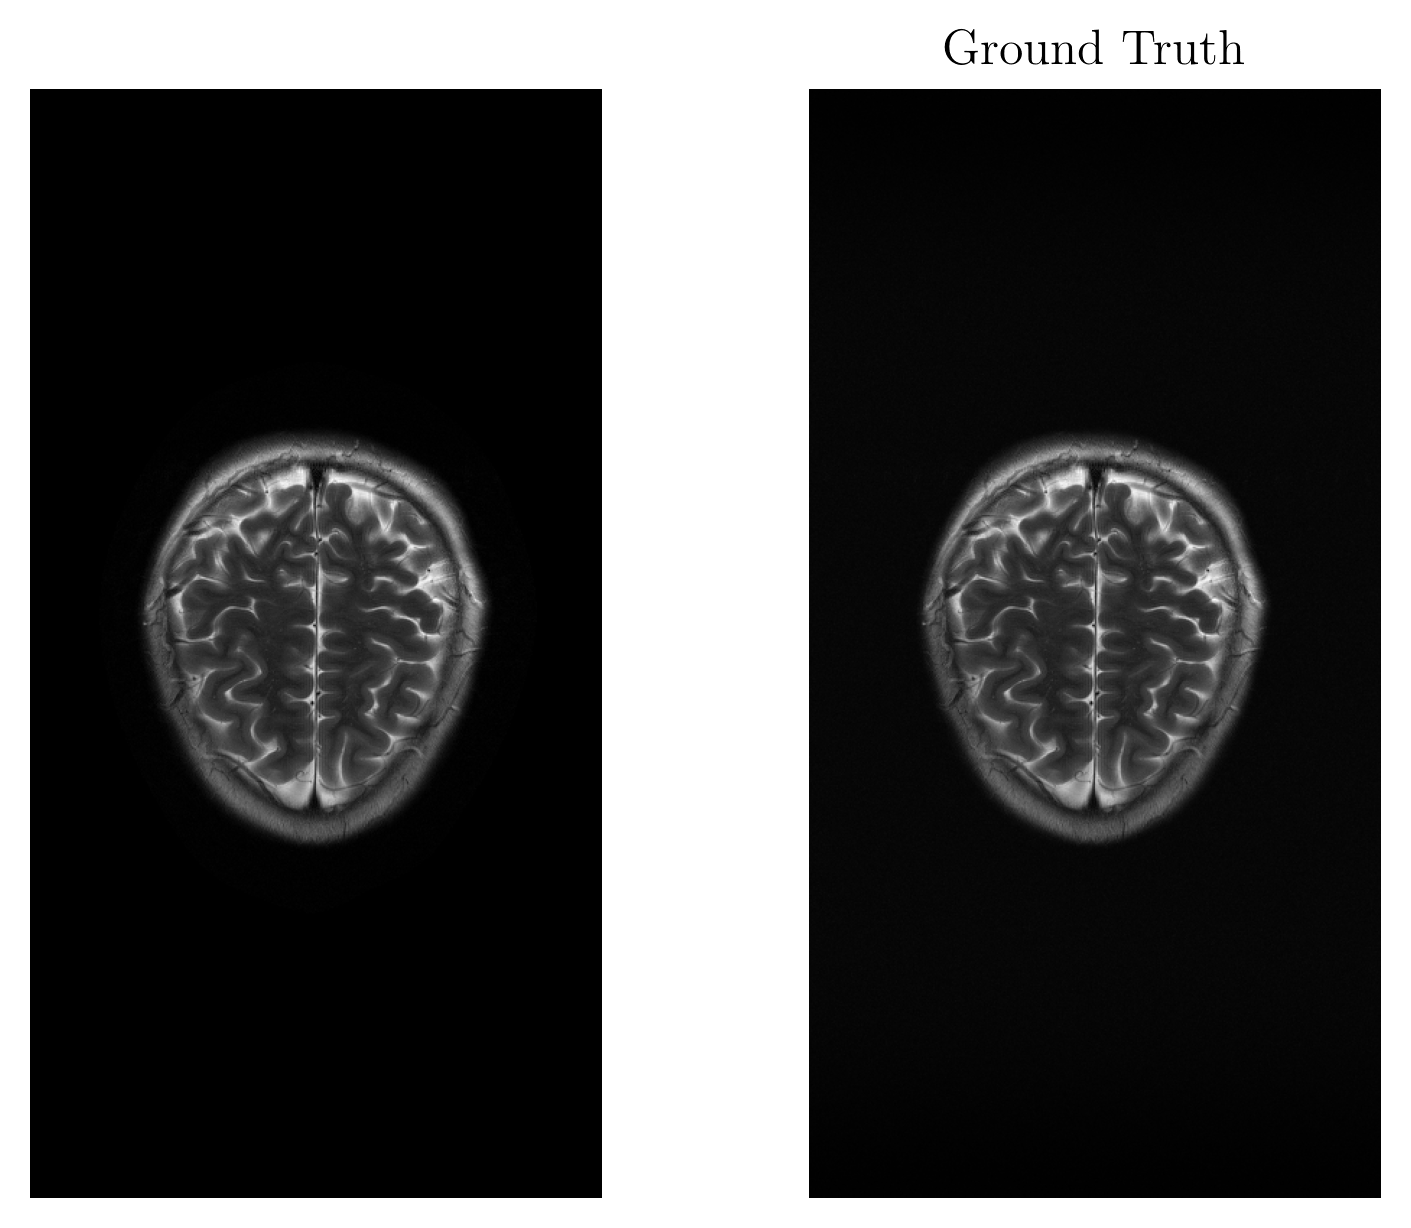

In [16]:
fig, axes = plt.subplots(1, 2, dpi= 300)

axes[0].imshow(target_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[0].axis('off')

axes[1].imshow(target_image_1c_.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('Ground Truth')
axes[1].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()